In [1]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-05-19
# For ICROS2023
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

# with DIGIT-sensor
# pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io
import datetime

from Function.ReceptiveField import *
from Function.SNNModule import *
from Function.plot_SNN import *
from Function.SNN import *
from Function.Stimulation_GPU import *


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Check if GPU is available and print the CUDA version
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the device to 'cpu'
device = 'cpu'
print(f"Using device: {device}")
# Start of the SNN (Spiking Neural Network) code

GPU available: True
CUDA version: 10.1
Using device: cpu


In [5]:
# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16
# Set pixel dimensions (number of pixels in height and width)
pixel_h, pixel_w = 320, 240
# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

In [6]:
#1st layer
############################################################################################################################################################
# Generate Slowly Adapting (SA) and Rapidly Adapting (RA) receptive fields
SA_RF, [SA_rf_height, SA_rf_width] = generate_mechanoreceptor_to_afferent_rf(kernel_w=9, kernel_h=11, step_size=5, device=device)
RA_RF, [RA_rf_height, RA_rf_width] = generate_mechanoreceptor_to_afferent_rf(kernel_w=11, kernel_h=14, step_size=4, device=device)
# Print the shape of the SA_rf variable
print("SA_rf shape:", SA_RF.shape, 'with height =',SA_rf_height, 'with width =', SA_rf_width)
print("RA_rf shape:", RA_RF.shape, 'with height =',RA_rf_height, 'with width =', RA_rf_width)
############################################################################################################################################################

#2nd layer
############################################################################################################################################################
# Define optimized receptive fields and synaptic delays
CN_PN_RF = [torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]],device=device) * 4]
CN_IN_RF = [torch.tensor([[1, 1, 1], [1, 0, 1], [1, 1, 1]],device=device)]
CN_SD = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]

CN_INtoPN_RF = []

# Check if the sizes of the inner tensors are different and print the index
for i, (PN, IN) in enumerate(zip(CN_PN_RF, CN_IN_RF)):
    if PN.size() != IN.size():
        raise ValueError(
            f"The inner tensors at index {i} have different sizes: {PN.size()} != {IN.size()}")

SA_CN_PN_RF, [SA_CN_PN_step_height, SA_CN_PN_step_width] = generate_weight(CN_PN_RF, pixel_h=SA_rf_height,pixel_w=SA_rf_width, step_size=1, device=device)
SA_CN_IN_RF, [SA_CN_IN_step_height, SA_CN_IN_step_width] = generate_weight(CN_IN_RF, pixel_h=SA_rf_height,pixel_w=SA_rf_width, step_size=1, device=device)
SA_CN_SD, [SA_CN_SD_step_height, SA_CN_SD_step_width]  = generate_weight(CN_SD, pixel_h=SA_rf_height,pixel_w=SA_rf_width, step_size=1, device=device)
RA_CN_PN_RF, [RA_CN_PN_step_height, RA_CN_PN_step_width] = generate_weight(CN_PN_RF, pixel_h=RA_rf_height,pixel_w=RA_rf_width, step_size=1, device=device)
RA_CN_IN_RF, [RA_CN_IN_step_height, RA_CN_IN_step_width] = generate_weight(CN_IN_RF, pixel_h=RA_rf_height,pixel_w=RA_rf_width, step_size=1, device=device)
RA_CN_SD, [RA_CN_SD_step_height, RA_CN_SD_step_width] = generate_weight(CN_SD, pixel_h=RA_rf_height, pixel_w=RA_rf_width, step_size=1, device=device)

SA_INtoPN_RF, SA_INtoPN_DN = create_weight_matrix(len(SA_CN_IN_RF), len(SA_CN_PN_RF), connection_probability=0.2, device=device)
RA_INtoPN_RF, RA_INtoPN_DN = create_weight_matrix(len(RA_CN_IN_RF), len(RA_CN_PN_RF), connection_probability=0.2, device=device)

print("SA_CN_PN_RF shape: ", SA_CN_PN_RF.shape,"SA_CN_PN_step_height:", SA_CN_PN_step_height,"SA_CN_PN_step_width:", SA_CN_PN_step_width)
print("SA_CN_IN_RF shape: ", SA_CN_IN_RF.shape,"SA_CN_IN_step_height:", SA_CN_IN_step_height,"SA_CN_IN_step_width:", SA_CN_IN_step_width)
print("RA_CN_PN_RF shape: ", RA_CN_PN_RF.shape,"RA_CN_PN_step_height:", RA_CN_PN_step_height,"RA_CN_PN_step_width:", RA_CN_PN_step_width)
print("RA_CN_IN_RF shape: ", RA_CN_IN_RF.shape,"RA_CN_IN_step_height:", RA_CN_IN_step_height,"RA_CN_IN_step_width:", RA_CN_IN_step_width)
print("SA_INtoPN_RF shape: ", SA_INtoPN_RF.shape)
print("RA_INtoPN_RF shape: ", RA_INtoPN_RF.shape)
############################################################################################################################################################

#3rd layer
############################################################################################################################################################
# 3rd integration layer
# Define optimized receptive fields and synaptic delays
CN_PN_RF_set = [torch.tensor([[0, 0, 0], [0, 0, 0], [1, 1 ,1]], device=device),torch.tensor([[0, 0, 1], [0, 0, 1], [0, 0 ,1]], device=device),
                torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], device=device),torch.tensor([[0, 0, 1], [0, 1, 0], [1, 0, 0]], device=device)]
CN_IN_RF_set = [torch.tensor([[0, 0, 0], [1, 1 ,1], [0, 0 ,0]], device=device),torch.tensor([[0, 1, 0], [0, 1 ,0], [0, 1 ,0]], device=device),
                torch.tensor([[0, 1, 0], [0, 0, 1], [0, 0, 0]], device=device)*3/2,torch.tensor([[0, 1, 0], [1, 0, 0], [0, 0, 0]], device=device)*3/2]
CN_SD_set = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),
             torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]
rf_sizes=[(7, 4)]

CN_PN_RF_RA_set = [torch.tensor([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[1, 1, 1 ,1, 1], [1, 1, 1 ,1, 1]], device=device)/10*3,
                   torch.tensor([[0, 0, 0, 1, 1], [0, 0, 0, 1, 1],[0, 0, 0, 1, 1],[0, 0, 0 ,1, 1], [0, 0, 0 ,1, 1]], device=device)/10*3,
                   torch.tensor([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]], device=device)/5*3,
                   torch.tensor([[0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0]], device=device)/5*3]

CN_IN_RF_RA_set = [torch.tensor([[0, 0, 0, 0, 0], [1, 1, 1 ,1, 1], [1, 1, 1 ,1, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], device=device)/10*3,
                   torch.tensor([[0, 1, 1, 0, 0], [0, 1, 1, 0, 0],[0, 1, 1, 0, 0],[0, 1, 1, 0, 0], [0, 1, 1, 0, 0]], device=device)/10*3,
                   torch.tensor([[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]], device=device)/5*3,
                   torch.tensor([[0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0]], device=device)/5*3,]

CN_SD__RA_set = [torch.tensor([[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2]], device=device),
                 torch.tensor([[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2]], device=device),
                 torch.tensor([[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2]], device=device),
                 torch.tensor([[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2]], device=device)]


# CN_PN_RF, CN_PN_DN = create_weight_matrix(len(SA_CN_PN_RF)+len(RA_CN_PN_RF),num_output_neuron,connection_probability = 0.2, device = device)
CN_PN_SA_RF, [CN_PN_SA_RF_step_height, CN_PN_SA_RF_step_width] = generate_weight(CN_PN_RF_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)
CN_IN_SA_RF, [CN_IN_SA_RF_step_height, CN_IN_SA_RF_step_width] = generate_weight(CN_IN_RF_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)
CN_SA_SD, [CN_SA_SD_step_height, CN_SA_SD_step_width] = generate_weight(
    CN_SD_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)

CN_PN_RA_RF, [CN_PN_RA_RF_step_height, CN_PN_RA_RF_step_width] = generate_weight(CN_PN_RF_RA_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)
CN_IN_RA_RF, [CN_IN_RA_RF_step_height, CN_IN_RA_RF_step_width] = generate_weight(CN_IN_RF_RA_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)
CN_RA_SD, [CN_RA_SD_step_height, CN_RA_SD_step_width] = generate_weight(
    CN_SD__RA_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)

CN_INtoPN_RF, CN_INtoPN_DN = create_weight_matrix(len(CN_IN_SA_RF), len(CN_PN_SA_RF), connection_probability=0.2, device=device)

print("CN_PN_SA_RF shape: ", CN_PN_SA_RF.shape, "CN_PN_SA_RF_step_height:", CN_PN_SA_RF_step_height, "CN_PN_SA_RF_step_width:", CN_PN_SA_RF_step_width)
print("CN_IN_SA_RF shape: ", CN_IN_SA_RF.shape, "CN_IN_SA_RF_step_height:", CN_IN_SA_RF_step_height, "CN_IN_SA_RF_step_width:", CN_IN_SA_RF_step_width)
print("CN_PN_RA_RF shape: ", CN_PN_RA_RF.shape, "CN_PN_RA_RF_step_height:", CN_PN_RA_RF_step_height, "CN_PN_RA_RF_step_width:", CN_PN_RA_RF_step_width)
print("CN_IN_RA_RF shape: ", CN_IN_RA_RF.shape, "CN_IN_RA_RF_step_height:", CN_IN_RA_RF_step_height, "CN_IN_RA_RF_step_width:", CN_IN_RA_RF_step_width)
print("CN_INtoPN_RF shape: ", CN_INtoPN_RF.shape)
############################################################################################################################################################

SA_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
RA_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
SA_CN_PN_RF shape:  torch.Size([54, 88]) SA_CN_PN_step_height: 9 SA_CN_PN_step_width: 6
SA_CN_IN_RF shape:  torch.Size([54, 88]) SA_CN_IN_step_height: 9 SA_CN_IN_step_width: 6
RA_CN_PN_RF shape:  torch.Size([88, 130]) RA_CN_PN_step_height: 11 RA_CN_PN_step_width: 8
RA_CN_IN_RF shape:  torch.Size([88, 130]) RA_CN_IN_step_height: 11 RA_CN_IN_step_width: 8
SA_INtoPN_RF shape:  torch.Size([54, 54])
RA_INtoPN_RF shape:  torch.Size([88, 88])
CN_PN_SA_RF shape:  torch.Size([112, 54]) CN_PN_SA_RF_step_height: 7 CN_PN_SA_RF_step_width: 4
CN_IN_SA_RF shape:  torch.Size([112, 54]) CN_IN_SA_RF_step_height: 7 CN_IN_SA_RF_step_width: 4
CN_PN_RA_RF shape:  torch.Size([112, 88]) CN_PN_RA_RF_step_height: 7 CN_PN_RA_RF_step_width: 4
CN_IN_RA_RF shape:  torch.Size([112, 88]) CN_IN_RA_RF_step_height: 7 CN_IN_RA_RF_step_width: 4
CN_INtoPN_RF shape:  torch.Size([112, 112]

In [ ]:
noise_std_val = 4

# Create Izhikevich layers
SA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_RF),v_thres=30, a_decay=1.02, noise_std = noise_std_val, device=device)
SA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(SA_CN_IN_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
SA_CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(SA_CN_PN_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)

RA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val,device=device)
RA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_CN_IN_RF),v_thres=30, a_decay=1, noise_std=noise_std_val, device=device)
RA_CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_CN_PN_RF),v_thres=30, a_decay=1,noise_std = noise_std_val, device=device)

SA_layers = [SA_layer, SA_CN_IN_layer, SA_CN_PN_layer]
RA_layers = [RA_layer, RA_CN_IN_layer, RA_CN_PN_layer]

SA_synapse = Synapse(SA_RF.to(device), device=device)
SA_CN_IN_synapse = Synapse(SA_CN_IN_RF.to(device), delays=SA_CN_SD, device=device)
SA_CN_PN_synapse = Synapse(SA_CN_PN_RF.to(device), delays=SA_CN_SD, device=device)
SA_CN_INtoPN_synapse = Synapse(SA_INtoPN_RF.to(device), delays = SA_INtoPN_DN, tau_psp = 10, device = device)

RA_synapse = Synapse(RA_RF.to(device), device=device)
RA_CN_IN_synapse = Synapse(RA_CN_IN_RF.to(device), delays=RA_CN_SD, device=device)
RA_CN_PN_synapse = Synapse(RA_CN_PN_RF.to(device), delays=RA_CN_SD, device=device)
RA_CN_INtoPN_synapse = Synapse(RA_INtoPN_RF.to(device), delays = RA_INtoPN_DN, tau_psp = 10, device = device)

SA_synapses = [SA_synapse, SA_CN_IN_synapse, SA_CN_PN_synapse, SA_CN_INtoPN_synapse]
RA_synapses = [RA_synapse, RA_CN_IN_synapse, RA_CN_PN_synapse, RA_CN_INtoPN_synapse]

# 3rd layer 
CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(CN_IN_SA_RF), v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(CN_PN_SA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)

CN_IN_SA_synapse = Synapse(CN_IN_SA_RF.to(device), delays=CN_SA_SD, device=device)
CN_PN_SA_synapse = Synapse(CN_PN_SA_RF.to(device), delays=CN_SA_SD, device=device)
CN_IN_RA_synapse = Synapse(CN_IN_RA_RF.to(device), delays=CN_RA_SD, device=device)
CN_PN_RA_synapse = Synapse(CN_PN_RA_RF.to(device), delays=CN_RA_SD, device=device)

CN_INtoPN_synapse = Synapse(CN_INtoPN_RF.to(device), delays = CN_INtoPN_DN, tau_psp = 10, device = device)

CN_layers = [CN_IN_layer, CN_PN_layer]
CN_synapses = [CN_IN_SA_synapse, CN_PN_SA_synapse, CN_IN_RA_synapse, CN_PN_RA_synapse, CN_INtoPN_synapse]



In [ ]:
plot_vmax, plot_vmin = 10,-10

sa_ind, ra_ind = 5, 5

plt.figure()
plt.imshow(CN_PN_SA_RF[sa_ind].reshape(9, 6) * 1 -
           CN_IN_SA_RF[sa_ind].reshape(9, 6), cmap='coolwarm')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(CN_PN_RA_RF[ra_ind].reshape(11, 8) * 1 -
           CN_IN_RA_RF[ra_ind].reshape(11, 8), cmap='coolwarm')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(torch.sum(SA_CN_PN_RF[torch.nonzero(CN_PN_SA_RF[sa_ind])], axis=0).reshape(11, 8) * 1
           - torch.sum(SA_CN_IN_RF[torch.nonzero(CN_IN_SA_RF[sa_ind])], axis = 0).reshape(11, 8) * 1, cmap='coolwarm')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure()
plt.imshow(torch.sum(RA_CN_PN_RF[torch.nonzero(CN_PN_RA_RF[ra_ind])],axis = 0).reshape(13,10)*1
 - torch.sum(RA_CN_IN_RF[torch.nonzero(CN_IN_RA_RF[ra_ind])],axis = 0).reshape(13,10)*1
 , cmap='coolwarm')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

weight = torch.sum(SA_CN_PN_RF[torch.nonzero(
    CN_PN_SA_RF[sa_ind])], axis=0) - torch.sum(SA_CN_IN_RF[torch.nonzero(CN_IN_SA_RF[sa_ind])], axis=0) * 1
sa_receptive_field = torch.matmul(weight, SA_RF)
plt.figure()
plt.imshow(sa_receptive_field.reshape(64, 48), cmap='coolwarm')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

weight = torch.sum(RA_CN_PN_RF[torch.nonzero(CN_PN_RA_RF[ra_ind])], axis=0) * 1 - torch.sum(RA_CN_IN_RF[torch.nonzero(CN_IN_RA_RF[ra_ind])], axis=0) * 1
ra_receptive_field = torch.matmul(weight, RA_RF)
plt.figure()
plt.imshow(ra_receptive_field.reshape(64, 48),
           cmap='coolwarm')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()


In [ ]:
num_stim = 1000

# Generate the stimuli and stack them up
F = 5
stimulation_angle_0_notmoving = generate_stimuli(0, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=True)
stimulation_angle_90_notmoving = generate_stimuli(90, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=True)
stimulation_angle_45_notmoving = generate_stimuli(45, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=True)
stimulation_angle_135_notmoving = generate_stimuli(135, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=True)

2023-05-22 13:50:45.188521
start feedforward


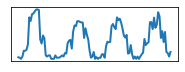

In [43]:
print(datetime.datetime.now())

S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device = device)

S.feedforward(stimulation_angle_0_notmoving)
plot_SNN(S)

2023-05-22 13:50:49.910538
start feedforward


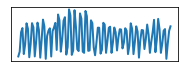

In [44]:
print(datetime.datetime.now())

S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device = device)

S.feedforward(stimulation_angle_90_notmoving)
plot_SNN(S)

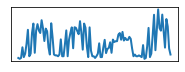

In [41]:
print(datetime.datetime.now())

S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device = device)

S.feedforward(stimulation_angle_45_notmoving)
plot_SNN(S)

2023-05-22 13:46:22.058717
start feedforward


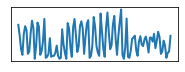

In [42]:
print(datetime.datetime.now())

S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device = device)

S.feedforward(stimulation_angle_135_notmoving)
plot_SNN(S)